<a href="https://colab.research.google.com/github/drscicomm/food-security/blob/main/LDA_FA_March_to_May_2020_20211020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount Drive and Upload Text Corpus

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
# upload file
from google.colab import files
uploaded = files.upload()

Saving data.csv to data.csv


Set up environment

In [1]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

In [2]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
stop_words = stopwords.words('english')
stop_words.extend(['ubi','co','lot','primary','clinic','get','flu','http','month','fyi','hour','https','along','consider','cold','people','make','provide','amp','nee','would','watch','word','rid','hi','\n','rt','\n\n', '&amp;', 'got', "it's", 'it’s', "i'm", 'i’m', 'im', 'want', 'like', '$', '@', 'RT', 'ur', '4'])

In [4]:
%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [5]:
pip install openpyxl==3.0.7

In [6]:
import os

os.chdir('..')

Load excel file and read into pandas dataframe

In [7]:
# Read data into dataframe
df = pd.read_csv('/content/data.csv')

In [8]:
# Print head
df.head()

,author id,created_at,geo,id,lang,like_count,quote_count,reply_count,retweet_count,source,tweet
0,1.457417e+07,2020-03-30 23:59:59+00:00,,1.244780e+18,en,0,0,0,943,Twitter for Android,RT @LiataisLibrary: The last week of any given...
1,2.833046e+09,2020-03-30 23:59:59+00:00,,1.244780e+18,und,0,0,0,8,TweetDeck,RT @jjfox123: @GottaBeZen @JoshuaPotash https:...
2,1.146530e+18,2020-03-30 23:59:58+00:00,,1.244780e+18,en,2,0,1,0,Twitter for Android,@_samucarla_ @EliteNetflix I need to ask somet...
3,4.019027e+07,2020-03-30 23:59:57+00:00,,1.244780e+18,en,0,0,0,26,Twitter Web App,RT @inquirerdotnet: The insistence of local go...
4,4.572149e+08,2020-03-30 23:59:57+00:00,,1.244780e+18,en,0,0,0,113,Twitter for Android,RT @PFIOfficial: Popular Front Chennai members...


#Sidebar: Exploratory Data Analysis

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2829 entries, 0 to 2828
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   author id      2829 non-null   float64
 1   created_at     2829 non-null   object 
 2   geo            2829 non-null   object 
 3   id             2829 non-null   float64
 4   lang           2829 non-null   object 
 5   like_count     2829 non-null   int64  
 6   quote_count    2829 non-null   int64  
 7   reply_count    2829 non-null   int64  
 8   retweet_count  2829 non-null   int64  
 9   source         2829 non-null   object 
 10  tweet          2829 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 243.2+ KB


In [13]:
df['source'].value_counts()

Twitter for iPhone            1339
Twitter for Android            747
Twitter Web App                468
Twitter for iPad               107
Twitter Web Client              36
OLIO Articles Plugin            26
TweetDeck                       22
Instagram                       11
WordPress.com                    7
SocialNewsDesk                   6
Tweetbot for iΟS                 5
Sprout Social                    5
IFTTT                            5
Twitterrific for iOS             4
Buffer                           3
dlvr.it                          3
Twitter for Advertisers.         3
Hootsuite Inc.                   2
Penname                          1
Clickongh                        1
megbot                           1
Twidere for Android              1
Listia                           1
COVID-19arXiv                    1
All 435 Reps                     1
Echofon                          1
apptegy                          1
Tweetlogix                       1
Twitter Media Studio

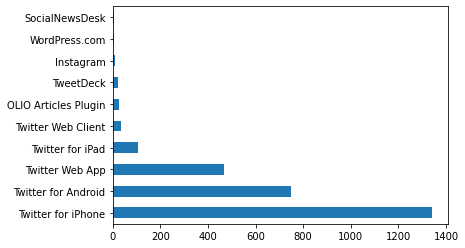

In [14]:
#plot
df['source'].value_counts()[:10].plot(kind='barh')

In [15]:
# put source into dataframe for export
df['source'].value_counts().to_frame()

,source
Twitter for iPhone,1339
Twitter for Android,747
Twitter Web App,468
Twitter for iPad,107
Twitter Web Client,36
OLIO Articles Plugin,26
TweetDeck,22
Instagram,11
WordPress.com,7
SocialNewsDesk,6


In [16]:
df['source'].value_counts().to_excel("source.xlsx")  

#Preprocessing

In [10]:
#drop spaces
df = df.dropna(subset=['tweet'])

In [11]:
# Remove punctuation
df['text_processed'] = \
df['tweet'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
df['text_processed'] = \
df['text_processed'].map(lambda x: x.lower())

# Print out the first rows of df
df['text_processed'].head()

0    rt @liataislibrary: the last week of any given...
1    rt @jjfox123: @gottabezen @joshuapotash https:...
2    @_samucarla_ @elitenetflix i need to ask somet...
3    rt @inquirerdotnet: the insistence of local go...
4    rt @pfiofficial: popular front chennai members...
Name: text_processed, dtype: object

In [12]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df.tweet.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['rt', 'the', 'last', 'week', 'of', 'any', 'given', 'month', 'for', 'anyone', 'on', 'ssi', 'ssdi', 'wic', 'and', 'or', 'food', 'stamps', 'is', 'always', 'rough', 'the', 'amount', 'paid', 'help']]


Build the Bigram, Trigram Models and Lemmatize

In [13]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


#Evaluation

Determine optimal number of topics, *c_v*

In [17]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_ready, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [18]:
import numpy as np
import tqdm
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(corpus,  int(num_of_docs*0.75)), 
               corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

  0%|          | 0/540 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
100%|██████████| 540/540 [1:20:26<00:00,  8.94s/it]


In [19]:
model_results1 = pd.DataFrame(model_results)
model_results1.head()

,Validation_Set,Topics,Alpha,Beta,Coherence
0,75% Corpus,2,0.01,0.01,0.355322
1,75% Corpus,2,0.01,0.31,0.277800
2,75% Corpus,2,0.01,0.61,0.313846
3,75% Corpus,2,0.01,0.91,0.345903
4,75% Corpus,2,0.01,symmetric,0.254220


Text(0.5, 1.0, 'Topic coherence')

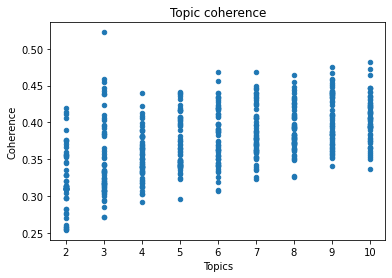

In [20]:

# Show graph

model_results1.plot(x ='Topics', y='Coherence', kind = 'scatter')
plt.title('Topic coherence')

In [21]:
#export to excel
model_results1.to_excel("coherence evaluation.xlsx")

In [22]:
# coherence scores, alpha and beta set at .01
# upload file
from google.colab import files
uploaded = files.upload()

Saving coherence pick.xlsx to coherence pick.xlsx


In [24]:
# Read data into dataframe
coherence_topics = pd.read_excel('/coherence pick.xlsx')

In [25]:
coherence_topics.head()

,Topics,Alpha,Beta,Coherence
0,2,0.01,0.01,0.355322
1,3,0.01,0.01,0.442807
2,4,0.01,0.01,0.367966
3,5,0.01,0.01,0.441517
4,6,0.01,0.01,0.422360


Text(0.5, 1.0, 'Topic coherence')

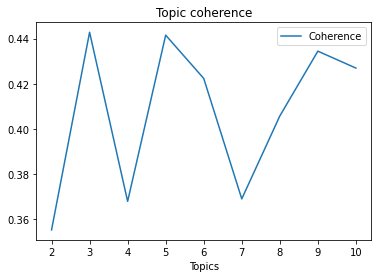

In [26]:
# Show graph

coherence_topics.plot(x ='Topics', y='Coherence', kind = 'line')
plt.title('Topic coherence')

In [27]:
# select best alpha and beta parameters ( for k = 9, look at highest coherence score and select corresponding alpha and beta)
uploaded = files.upload()

Saving best alpha beta.xlsx to best alpha beta.xlsx


In [28]:
# Read data into dataframe
best_alphabeta = pd.read_excel('/best alpha beta.xlsx')

In [29]:
best_alphabeta.head()

,Alpha,Beta,Coherence
0,0.91,0.01,0.458832
1,0.61,0.01,0.447179
2,0.01,0.01,0.442807
3,asymmetric,0.01,0.439165
4,symmetric,0.01,0.403498


Choosing Alpha=.91, Beta=.01 k=3

Build the topic model

In [14]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha=.91,
                                            eta=.01,
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


[(0,
  '0.585*"ask" + 0.218*"need" + 0.039*"stamp" + 0.028*"meal" + 0.026*"help" + '
  '0.023*"give" + 0.020*"share" + 0.016*"distribution" + 0.007*"offer" + '
  '0.007*"school"'),
 (1,
  '0.944*"food" + 0.014*"covid" + 0.010*"distribute" + 0.007*"support" + '
  '0.003*"lockdown" + 0.002*"local" + 0.002*"member" + 0.001*"pantry" + '
  '0.000*"relief" + 0.000*"visit"'),
 (2,
  '0.483*"food" + 0.465*"donation" + 0.025*"go" + 0.009*"emergency" + '
  '0.002*"grocery" + 0.000*"lunch" + 0.000*"homelessness" + 0.000*"majority" + '
  '0.000*"lack" + 0.000*"dinner"')]


What is the Dominant topic and its percentage contribution in each document

In [15]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(28)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.5810,"ask, need, stamp, meal, help, give, share, dis...","[give, food, stamp, help]"
1,1,0.0,0.3333,"ask, need, stamp, meal, help, give, share, dis...",[]
2,2,0.0,0.6074,"ask, need, stamp, meal, help, give, share, dis...","[ask, vend, lunch, break, offer, share, food, ..."
3,3,0.0,0.4038,"ask, need, stamp, meal, help, give, share, dis...","[insistence, local, government, enforce, quara..."
4,4,1.0,0.7870,"food, covid, distribute, support, lockdown, lo...","[popular, member, distribute, food, relief, ma..."
5,5,0.0,0.5121,"ask, need, stamp, meal, help, give, share, dis...","[slough, base, hot, meal, daily, hospital]"
6,6,1.0,0.4879,"food, covid, distribute, support, lockdown, lo...","[current, information, food, distribution, loc..."
7,7,0.0,0.5810,"ask, need, stamp, meal, help, give, share, dis...","[school, meal, child, food, voucher]"
8,8,2.0,0.7744,"food, donation, go, emergency, grocery, lunch,...","[reminder, sinfamily, food, emergency, go, gro..."
9,9,1.0,0.5939,"food, covid, distribute, support, lockdown, lo...","[donation, local, food, pantry, support, syste..."


In [16]:
# save as excel
df_dominant_topic.to_excel('df_dominant_topic.xlsx')

The most representative sentence for each topic

In [17]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(8)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.7102,"ask, need, stamp, meal, help, give, share, distribution, offer, school","[stand, proud, texan, use, rainy, day, fund, help, child, heartbreake, long, line, berry, food, ..."
1,1.0,0.7870,"food, covid, distribute, support, lockdown, local, member, pantry, relief, visit","[popular, member, distribute, food, relief, material, labourer, strand, due, lockdown, covid]"
2,2.0,0.7744,"food, donation, go, emergency, grocery, lunch, homelessness, majority, lack, dinner","[reminder, sinfamily, food, emergency, go, grocery, shopping, snap, go, begin, food, insecurity,..."


In [18]:
sent_topics_sorteddf_mallet.to_excel('topics.xlsx')

# Word clouds

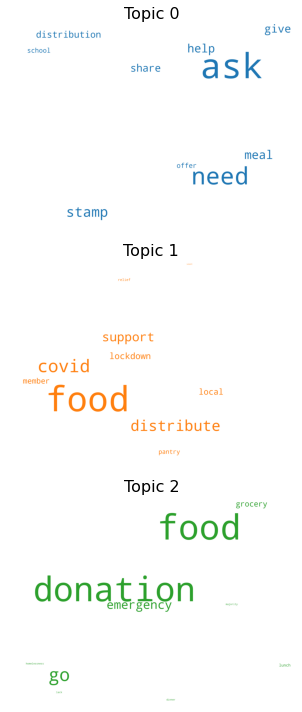

In [19]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 1, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

Word Counts of Topic Keywords

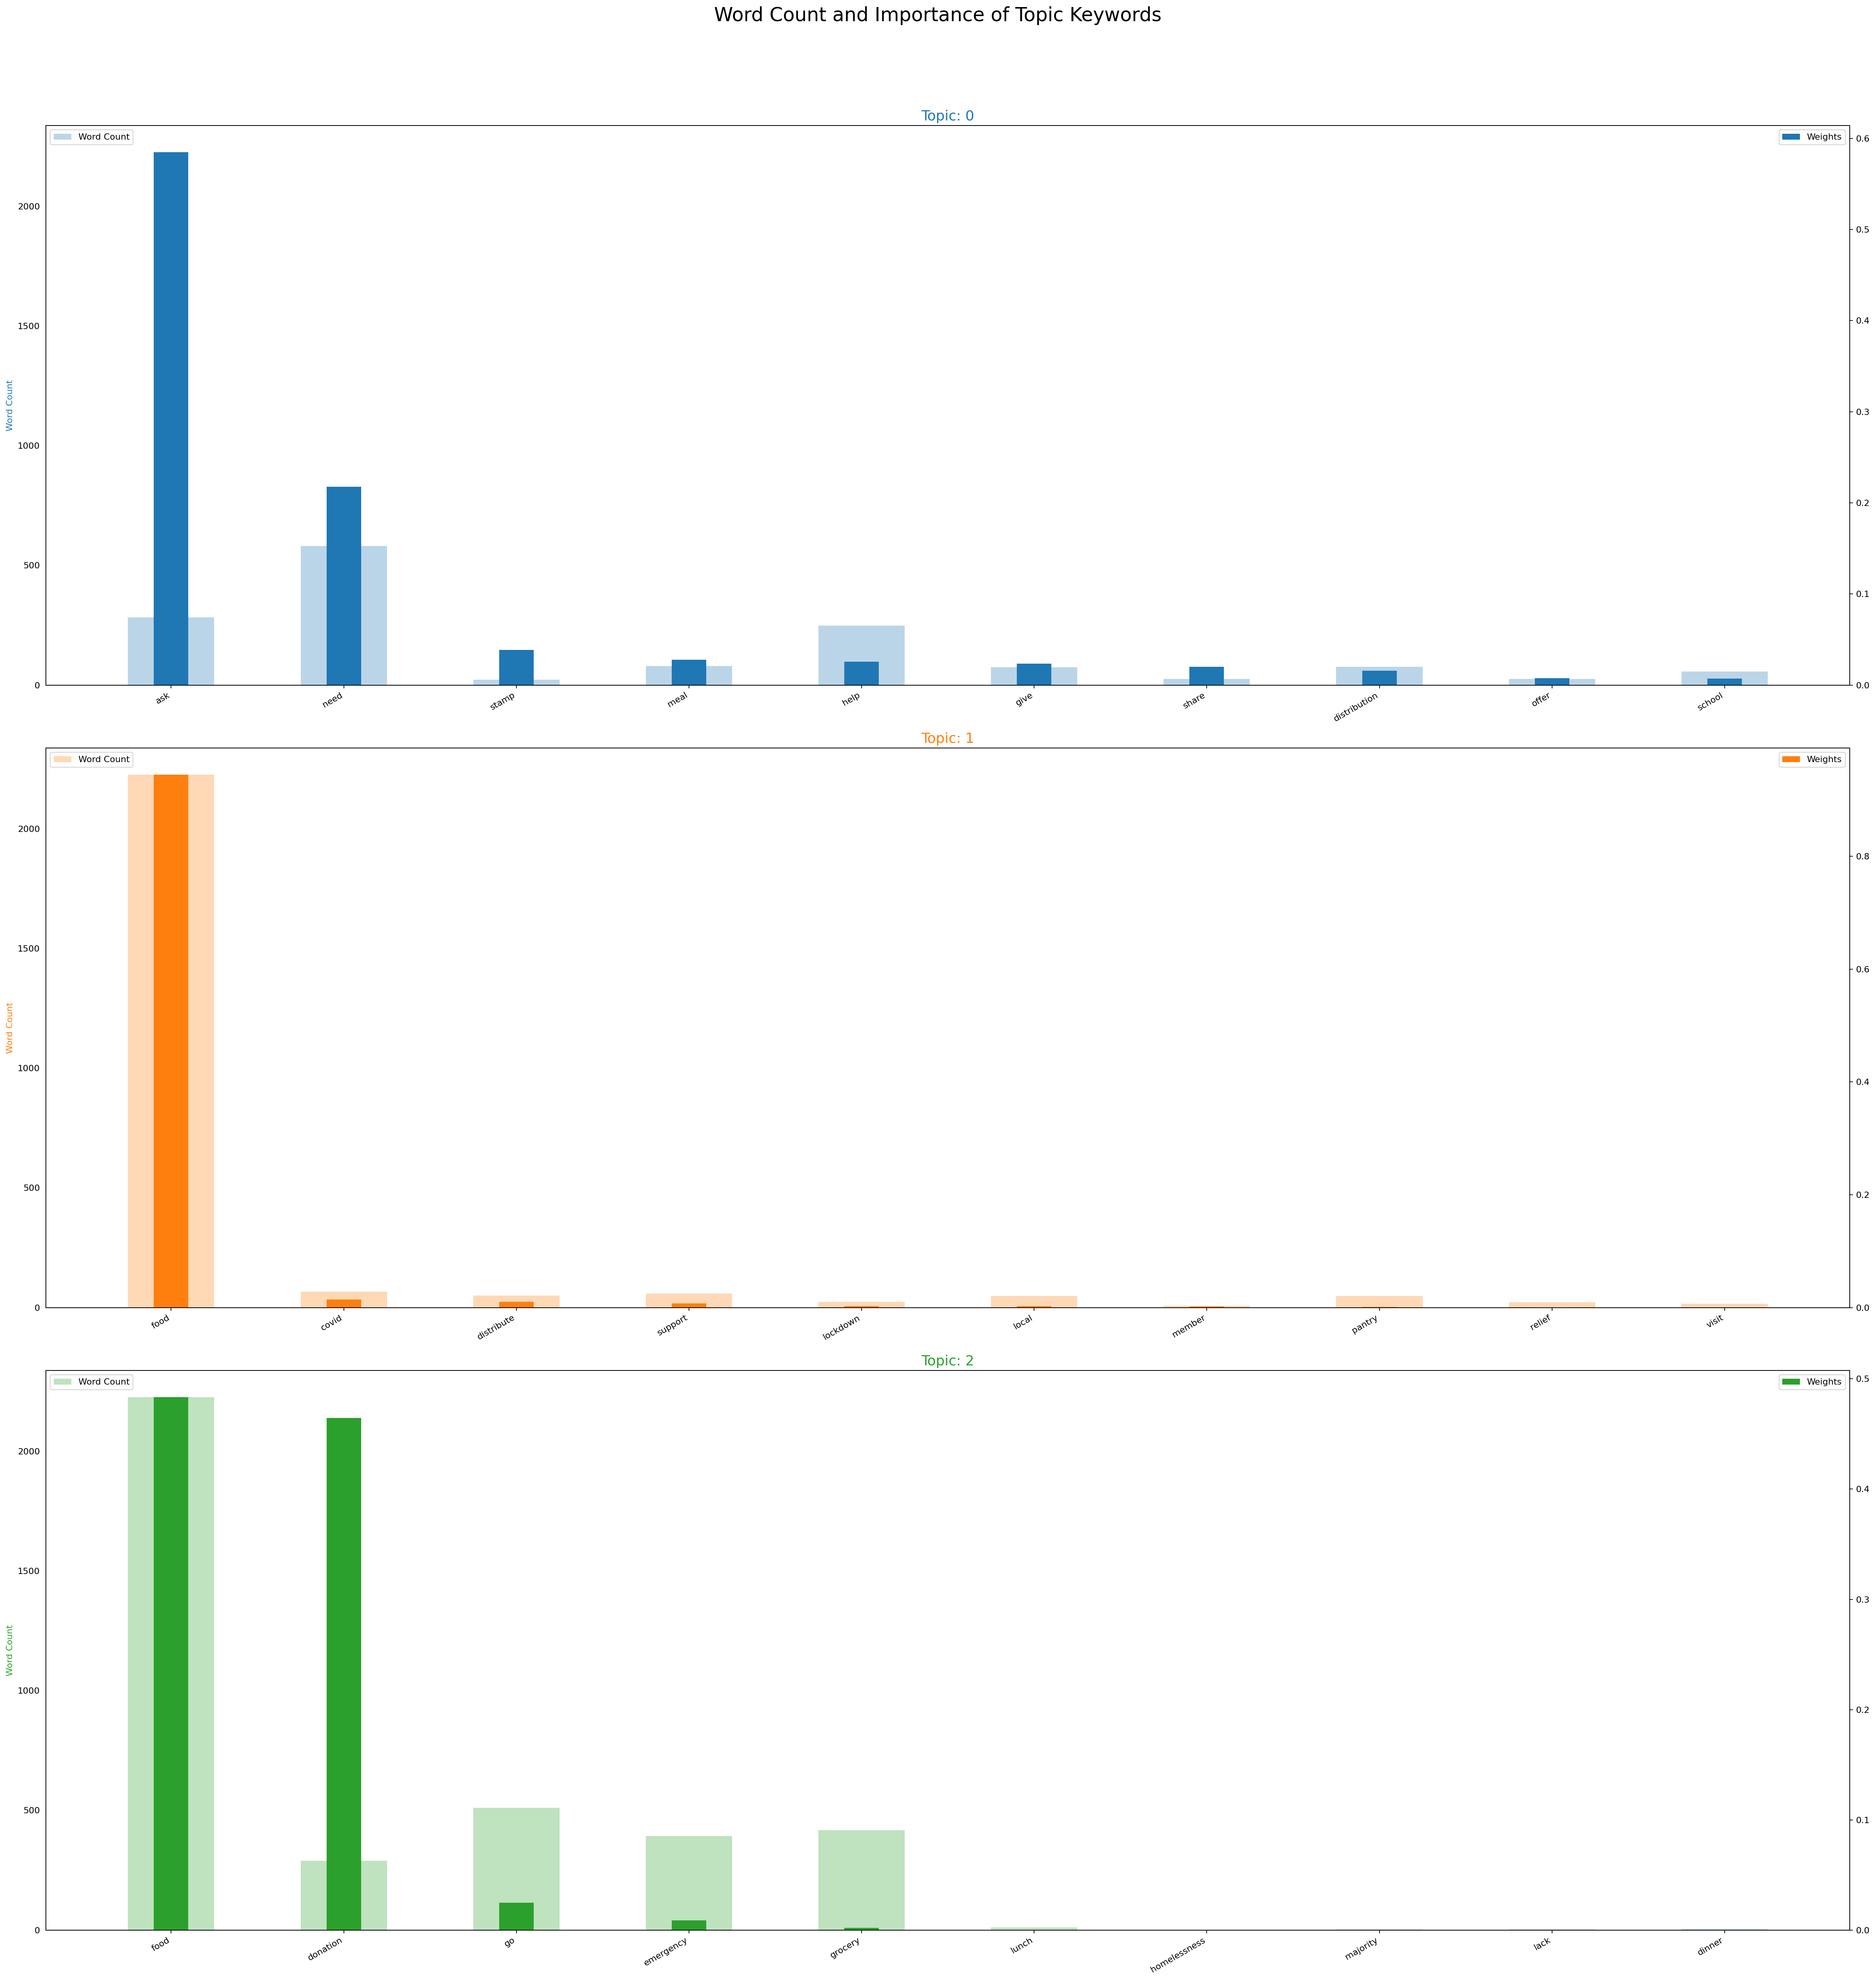

In [20]:
# When it comes to the keywords in the topics, the importance (weights) of the keywords matters. 
# Along with that, how frequently the words have appeared in the documents is also interesting to look.
# Let’s plot the word counts and the weights of each keyword in the same chart.
#You want to keep an eye out on the words that occur in multiple topics and the ones whose relative frequency 
# is more than the weight. Often such words turn out to be less important. 
# The chart I’ve drawn below is a result of adding several such words to the stop words list in the beginning and 
# re-running the training process.

from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 1, figsize=(30,30), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    #ax_twin.set_ylim(0, 0.050); ax.set_ylim(0, 1000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [21]:
df.head()

,word,topic_id,importance,word_count
0,ask,0,0.584725,283
1,need,0,0.217551,581
2,stamp,0,0.038693,22
3,meal,0,0.027921,80
4,help,0,0.025522,249


In [22]:
df.to_excel('word-importance.xlsx')

Sentence Chart Colored by Topic

> Each word in the document is representative of one of the 8 topics. Let’s color each word in the given documents by the topic id it is attributed to.
The color of the enclosing rectangle is the topic assigned to the document.



IndexError: ignored

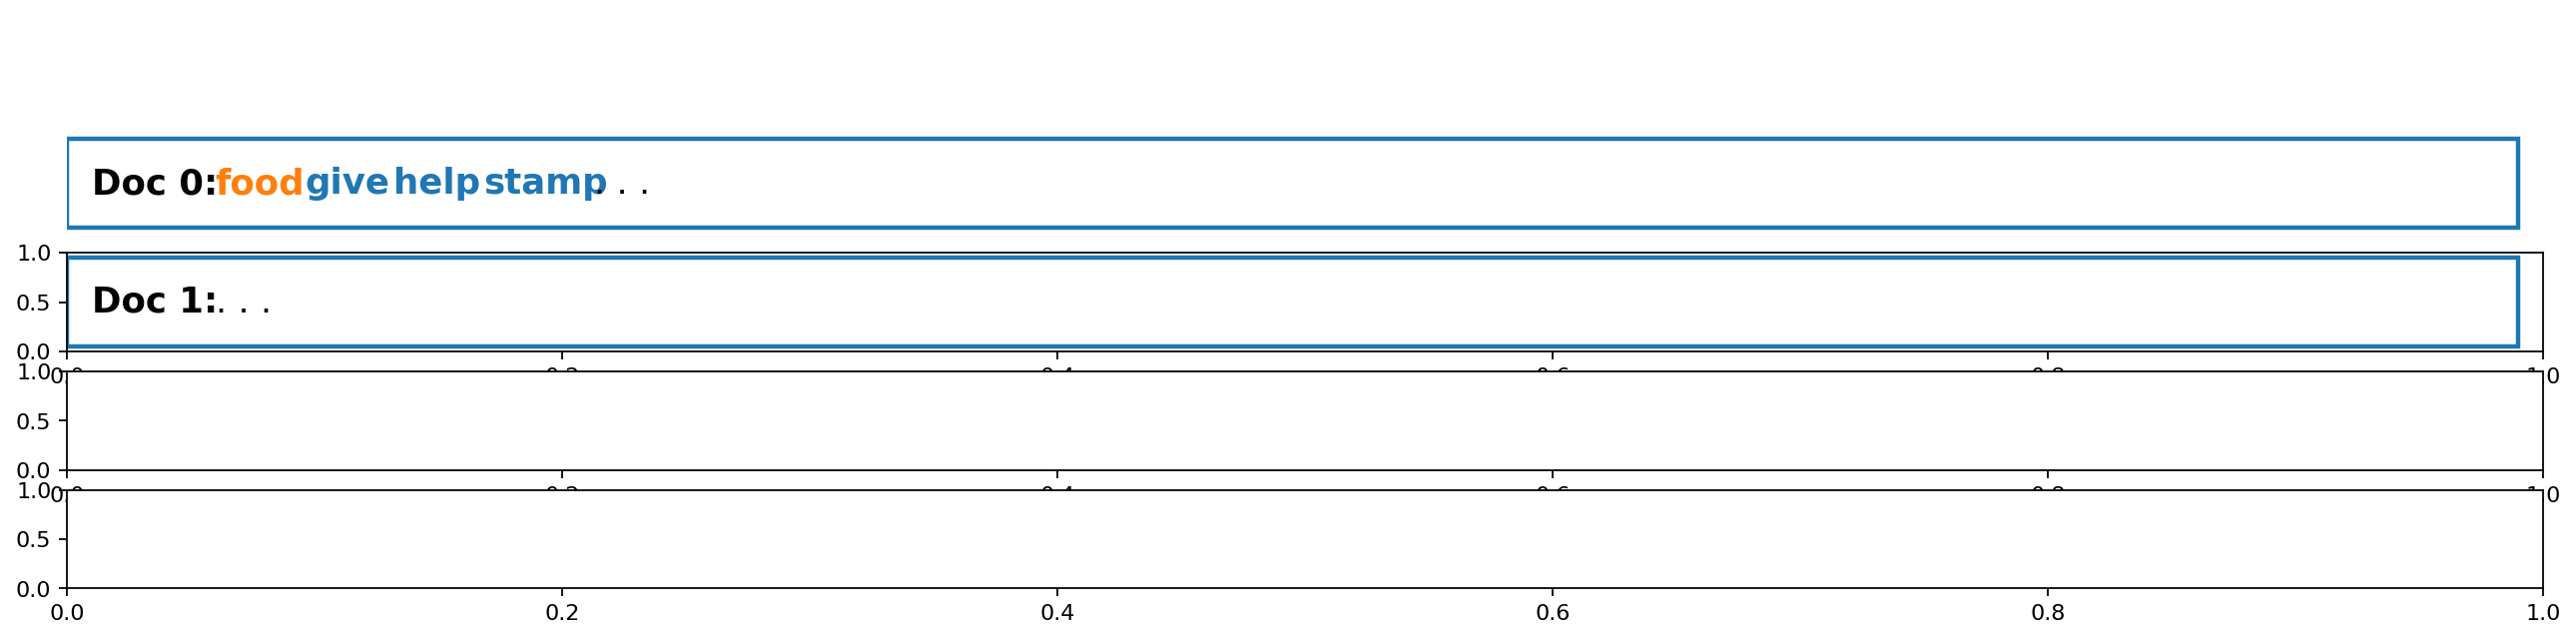

In [23]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 5):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

What are the most discussed topics in the documents?

In [24]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

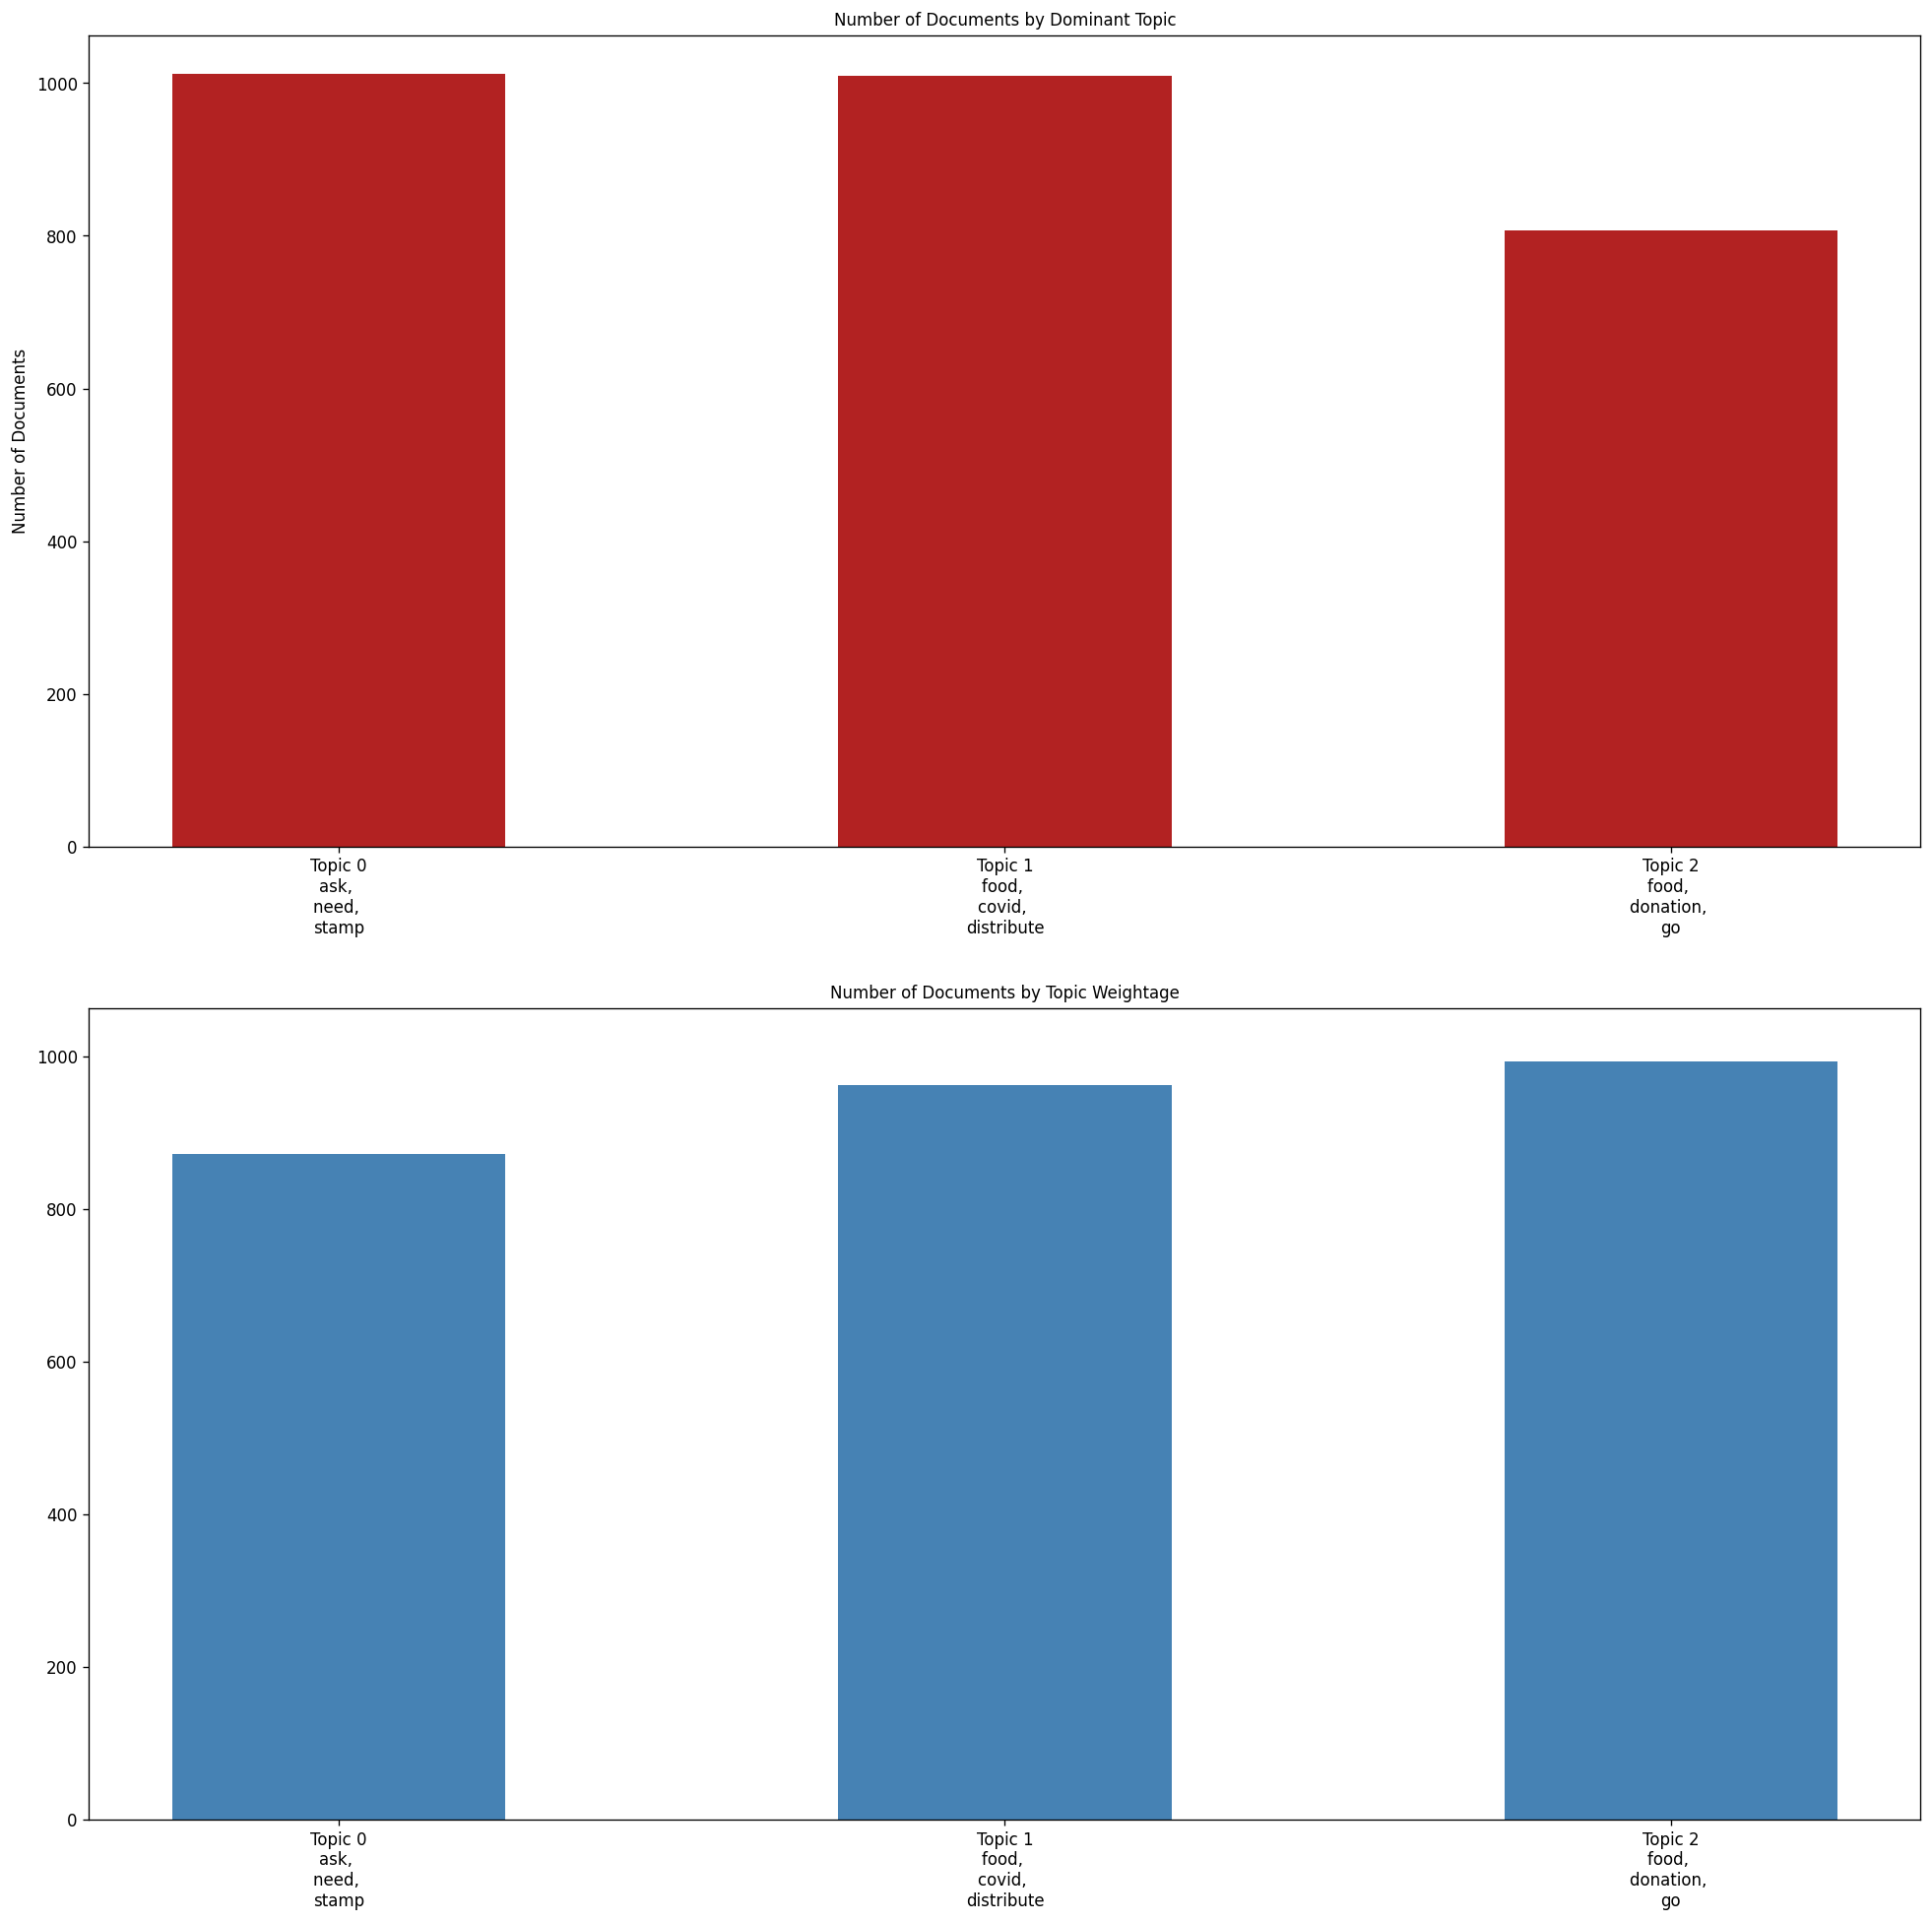

In [25]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
#ax1.set_ylim(0, 10)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

t-SNE Clustering Chart

In [26]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2479 samples in 0.002s...
[t-SNE] Computed neighbors for 2479 samples in 0.035s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2479
[t-SNE] Computed conditional probabilities for sample 2000 / 2479
[t-SNE] Computed conditional probabilities for sample 2479 / 2479
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.174141
[t-SNE] KL divergence after 1000 iterations: 0.084292


In [74]:
# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 9
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

In [27]:
pip install pyLDAvis

In [28]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [29]:
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.223793 -0.112439       1        1  34.826351
2     -0.223352  0.112513       2        1  33.231594
0      0.447145 -0.000074       3        1  31.942055, topic_info=          Term          Freq         Total Category  logprob  loglift
4          ask   4293.000000   4293.000000  Default  30.0000  30.0000
0         food  11254.000000  11254.000000  Default  29.0000  29.0000
60    donation   3550.000000   3550.000000  Default  28.0000  28.0000
61        need   1597.000000   1597.000000  Default  27.0000  27.0000
3        stamp    284.000000    284.000000  Default  26.0000  26.0000
..         ...           ...           ...      ...      ...      ...
0         food      0.052097  11254.439567   Topic3 -11.8562 -11.1419
8        lunch      0.052097      0.261997   Topic3 -11.8562  -0.4740
19       local      0.052097     18.963038   Topic3 -11.8562  -4.7559
23       covid      0.052097    116.122697   Topic3 -11.8562  -6.5680
24  distribute      0.052097     82.661314   Topic3 -11.8562  -6.2281

[147 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
4         3  1.000000           ask
5         3  1.058913         break
45        3  0.993452         child
23        1  0.998943         covid
24        1  1.004097    distribute
41        3  0.997406  distribution
60        2  0.999957      donation
49        2  0.991500     emergency
0         1  0.671913          food
0         2  0.328137          food
1         3  0.999346          give
51        2  1.000746            go
17        3  1.062284    government
52        2  0.985024       grocery
2         3  0.997310          help
19        1  1.001949         local
27        1  0.984526      lockdown
37        3  0.999418          meal
29        1  1.019300        member
61        3  1.000209          need
9         3  1.001892         offer
62        1  0.939323        pantry
31        1  1.197765        relief
46        3  0.999461        school
10        3  0.997824         share
3         3  0.999207         stamp
63        1  0.997050       support
11        3  0.990850         thank, R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])